## ARMA

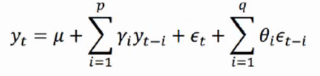

In [2]:
import tushare as ts
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pro = ts.pro_api()
pd.set_option('display.max_rows', 1000)

ModuleNotFoundError: No module named 'lxml'

# Prepare for data

## option info

In [ ]:
option_info_all = pro.opt_basic(
    exchange='SSE',
    call_put='C',
    fields='ts_code,name,exercise_price, list_date,delist_date,maturity_date')

option_info_all['period']=pd.to_datetime(option_info_all['delist_date']) - pd.to_datetime(option_info_all['list_date'])

option_info_all[option_info_all['maturity_date'].str.startswith('201806')]

## Select one

In [ ]:
CODE = "10001025.SH"
option_info_all[option_info_all.ts_code == CODE]

## Price data

In [ ]:
option_price = pro.opt_daily(ts_code=CODE ,fields= 'trade_date, close')

# clean
option_price.index = option_price.trade_date
option_price = option_price.drop(columns='trade_date')
option_price.index = pd.to_datetime(option_price.index)
option_price = option_price.sort_index()
option_price

In [ ]:
option_price.plot()

## split into Train & Test data

In [ ]:
sub = option_price.close
train = sub.loc[:'2019-01']
test = sub.loc['2019-02':]
sub



In [ ]:
train.plot()
train

In [ ]:
print(test)
test.plot()

# Difference

In [ ]:
option_price.shape

In [ ]:
option_price['close_diff_1'] = option_price['close'].diff(1)
option_price['close_diff_2'] = option_price['close'].diff(2)

option_price = option_price.dropna()
option_price

## Draw diff

In [ ]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
ax1.plot(option_price['close'])
ax2 = fig.add_subplot(132)
ax2.plot(option_price['close_diff_1'])
ax3 = fig.add_subplot(133)
ax3.plot(option_price['close_diff_2'])
plt.show()

## Test Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### origion

In [ ]:
test_stationarity(option_price['close'].dropna(inplace=False))

### diff_1

In [ ]:
test_stationarity(option_price['close_diff_1'].dropna(inplace=False))

# Draw Autocorrelation & Partial Autocorrelation

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(option_price['close'].loc[:'2019-01'], lags=15,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(option_price['close'].loc[:'2019-01'], lags=15, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(option_price['close_diff_1'].loc[:'2019-01'], lags=15,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(option_price['close_diff_1'].loc[:'2019-01'], lags=15, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()


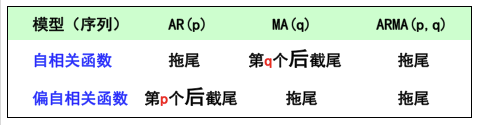

Autocorrelation
    1阶截尾
    
    
Partial Autocorrelation: 
    1阶截尾
    
    
    
ARMA(1,1)

## AIC & BIC

## AIC准则

AIC准则全称为全称是最小化信息量准则（Akaike Information Criterion），计算公式如下：


AIC = =2 *（模型参数的个数）-2ln（模型的极大似然函数）



## BIC准则


AIC准则存在一定的不足之处。


当样本容量很大时，在AIC准则中拟合误差提供的信息就要受到样本容量的放大，而参数个数的惩罚因子却和样本容量没关系（一直是2），因此当样本容量很大时，使用AIC准则选择的模型不收敛与真实模型，它通常比真实模型所含的未知参数个数要多。BIC（Bayesian InformationCriterion）贝叶斯信息准则弥补了AIC的不足，计算公式如下：


BIC = ln(n) * (模型中参数的个数) - 2ln(模型的极大似然函数值)，n是样本容量


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_results = sm.tsa.arma_order_select_ic(option_price['close_diff_1'].loc[:'2019-01'], ic=['aic', 'bic'], trend='nc', max_ar=5, max_ma=5)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)


## Draw resid


In [ ]:
model = sm.tsa.ARIMA(train, order=(1, 0, 0))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=18)
plt.show()
print(results.summary().tables[1])

In [ ]:
model = sm.tsa.ARIMA(train, order=(1, 1, 0))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=18)
plt.show()


In [ ]:
print(results.summary().tables[1])

In [ ]:
model = sm.tsa.ARIMA(sub, order=(1, 0, 0))
results = model.fit()
predict_sunspots = results.predict(start=1,end=150,dynamic=False)
print(predict_sunspots)

In [ ]:
def reverse_diff()
    x, x_diff = df['A'].iloc[0], df['B'].iloc[1:]
    df['C'] = np.r_[x, x_diff].cumsum().astype(int)
    


In [ ]:
#plt.figure(figsize=(12, 8))
plt.plot(predict_sunspots, label='ARMA(1,1,0) simulate')
plt.plot(option_price['close'], label='option_price')
plt.legend(loc='best')
plt.show()

In [ ]:
def draw_arima(p,d,q):
    model = sm.tsa.ARIMA(option_price['close'], order=(p,d,q))
    results = model.fit()
    predict_sunspots = results.predict(start=1,end=150,dynamic=False)
    plt.plot(predict_sunspots, label='ARMA(1,1,0) simulate')
    plt.plot(option_price['close'], label='option_price')
    plt.legend(loc='best')
    plt.show()
    return predict_sunspots
    
b = draw_arima(3,0,4)   

In [ ]:
def draw_arima_2(p,d,q):
    model = sm.tsa.ARIMA(option_price['close_diff_1'], order=(p,d,q))
    results = model.fit()
    predict_sunspots = results.predict(start=1,end=150,dynamic=False)
    plt.plot(predict_sunspots*10, label='ARMA(1,1,0) simulate')
    plt.plot(option_price['close_diff_1'], label='option_price')
    plt.legend(loc='best')
    plt.show()
    return predict_sunspots
    
diff_100 = draw_arima_2(1,0,0)   

In [ ]:
def draw_arima_3(p,d,q):
    model = sm.tsa.ARIMA(option_price['close'], order=(p,d,q))
    results = model.fit()
    predict_sunspots = results.predict(start=1,end=150,dynamic=False)
    plt.plot(predict_sunspots, label='ARMA(1,1,0) simulate')
    plt.plot(option_price['close_diff_1'], label='option_price')
    plt.legend(loc='best')
    plt.show()
    return predict_sunspots
    
origin_110 = draw_arima_3(1,1,0)   

In [ ]:
df = pd.DataFrame()

In [ ]:
df['diff_100'] = diff_100
df['origin_110'] =origin_110

In [ ]:
df['d_f'] = df['b'].diff(1)

In [ ]:
sub.index

In [ ]:
sub = option_price['close']
sub.index = range(160)
train = sub[:126]
test = sub[126:]

from pandas import datetime
# 2018-07-26
# 2019-01-31
# 2019-03-27

model = sm.tsa.ARIMA(train, order=(3,0,4))
results = model.fit()
index_num = len(train)
predict_sunspots = results.predict(start=126,end=130,dynamic=False)
plt.plot(predict_sunspots, label='fittedvalues')
plt.plot(test, label='real_value')
plt.legend(loc='best')
plt.show()
print(results.summary())


In [ ]:
sub = option_price['close']
train = sub.loc[:'2019-01']
test = sub.loc['2019-02':]


model = sm.tsa.ARIMA(train, order=(1,1,0))
results = model.fit()
plt.plot(results.fittedvalues, label='fittedvalues')
plt.plot(train.diff(1), label='real_value')
plt.legend(loc='best')
plt.show()
print(results.summary())

In [ ]:
sub = option_price['close_diff_1']
train = sub.loc[:'2019-01']
test = sub.loc['2019-02':]


model = sm.tsa.ARMA(train, order=(1,0))
results = model.fit()
plt.plot(results.fittedvalues, label='fittedvalues')
plt.plot(train, label='real_value')
plt.legend(loc='best')
plt.show()
print(results.summary())

In [ ]:
results.predict(1, 126, dynamic = True)

In [ ]:
results.fittedvalues